In [1]:
import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

import seaborn as snsm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import networkx as nx

from collections import Counter

import math, random

import json

from typing import Sequence, Optional, Callable, List

In [2]:
def interactive_embedding_plot_3D(W:np.ndarray,
                                encoder:dict,
                                decoder:dict,
                                words: Optional[Sequence[str]] = None,
                                method_graph: Optional[PCA|TSNE] = None,
                                method_cluster: Optional[KMeans] = None,
                                normalize_cluster:bool=True,
                                query_words: Optional[List[str]|str] = None,
                                top_k_neighbors: int = 10,
                                show_only: Optional[Sequence[str]] = None,
                                title: Optional[str] = None):
    """
    Trace un scatter interactif (Plotly) des embeddings.
    - embedding: nn.Embedding (poids seront copiés en cpu)
    - encoder: dict word -> idx
    - words: séquence de mots à afficher (par défaut tous les mots de encoder)
    - method: 'pca' ou {"perplexity": 30, "n_iter": 1000, "init": "pca", "learning_rate": 200}
    - tsne_params: dict de paramètres passés à TSNE si method == 'tsne'
    - top_k_neighbors: nombre de voisins affichés si query_word spécifié
    - query_word: si fourni, on le met en évidence et on affiche ses k voisins les plus proches
    - show_only: si fourni, restreint l'affichage à cette liste de mots
    - title: titre du graphique
    Retour: Plotly Figure (affiche inline si en notebook)
    """
    # Préparer la liste de mots à afficher
    if words is None:
        words = list(encoder.keys())
    words = list(words)

    if show_only is not None:
        show_set = set(show_only)
        words = [w for w in words if w in show_set]

    # Construire la matrice d'embeddings [N, D]
    idxs = [encoder[w] for w in words]


    # Réduction de dimension
    if method_graph is None:
        X = W
    else:
        X = method_graph.fit_transform(W)

    # Construire dataframe-like arrays
    xs = X[:,0]
    ys = X[:,1]
    zs = X[:,2]
    labels = words

    words_cluster = None
    if method_cluster is not None:
        w_norm = W
        if normalize_cluster:
            w_norm = normalize(W)
        method_cluster.fit(w_norm)
        words_cluster = method_cluster.labels_

    
    fig:go.Figure = px.scatter_3d(x=xs, y=ys, z=zs, hover_name=labels, title=(title or "Embeddings 3D"), color=words_cluster,
                    width=1000, height=800)
    
    # add invisible text markers for readability; show points as small markers
    # fig.update_traces(marker=dict(size=4, opacity=0.8))

    # If query_word provided, highlight it and its neighbors
    """if query_words is not None:
        if query_words not in encoder:
            raise KeyError(f"query_word '{query_words}' not found in encoder")
        # compute cosine similarities between query embedding and all displayed embeddings
        with torch.no_grad():
            query_idx = encoder[query_word]
            query_vec = embedding.weight.cpu().numpy()[query_idx:query_idx+1]  # [1, D]
            sims = cosine_similarity(query_vec, W).flatten()  # [N]
            # get top_k indices (exclude itself if present)
            order = np.argsort(-sims)
            # keep top_k_neighbors (including query if in list)
            topk = order[:top_k_neighbors]
        # build lines to neighbors and highlight markers
        neighbor_words = [labels[i] for i in topk]
        neighbor_sims = sims[topk]

        # highlight query point (if it's in displayed words)
        if query_word in labels:
            qpos = labels.index(query_word)
            fig.add_trace(go.Scatter3d(x=[xs[qpos]], y=[ys[qpos]], z=[zs[qpos]],
                           mode='markers+text',
                           marker=dict(size=8, color='red', symbol='diamond'),
                           text=[query_word], textposition='top center', name=f'query {query_word}'))
        # draw neighbors and lines
        for i, ni in enumerate(topk):
            if labels[ni] == query_word:
                continue
            fig.add_trace(go.Scatter3d(x=[xs[ni]], y=[ys[ni]], z=[zs[ni]],
                           mode='markers+text',
                           marker=dict(size=6, color='orange'),
                           text=[labels[ni]], textposition='top center',
                           name=f'neighbor_{i} (sim={neighbor_sims[i]:.3f}) {decoder[ni]}'))
            
            # line from query to neighbor if query is displayed
            if query_word in labels:
                fig.add_trace(go.Scatter3d(x=[xs[qpos], xs[ni]], y=[ys[qpos], ys[ni]], z=[zs[qpos], zs[ni]],
                           mode='lines', line=dict(width=2, color='gray'), showlegend=False))"""
    max_range = np.max(np.ptp(X, axis=0))  # plage maximale sur les composants projetés
    if max_range == 0:
        max_range = 1.0
    scale = max_range * 0.05  # longueur des axes (ajuste si besoin)

    # axes X, Y, Z : lignes de -scale à +scale
    axes_traces = [
        # X axis (rouge)
        go.Scatter3d(x=[-scale, scale], y=[0, 0], z=[0, 0],
                     mode='lines', line=dict(color='red', width=4), name='axis X'),
        # Y axis (vert)
        go.Scatter3d(x=[0, 0], y=[-scale, scale], z=[0, 0],
                     mode='lines', line=dict(color='green', width=4), name='axis Y'),
        # Z axis (bleu)
        go.Scatter3d(x=[0, 0], y=[0, 0], z=[-scale, scale],
                     mode='lines', line=dict(color='blue', width=4), name='axis Z'),
    ]

    # flèches aux extrémités (petits segments pour simuler des flèches) et labels
    arrow_len = scale * 0.008
    arrow_traces = []
    labels_traces = []
    # X positive arrow
    arrow_traces.append(go.Scatter3d(x=[scale, scale - arrow_len], y=[0, 0], z=[0, 0],
                                     mode='lines', line=dict(color='red', width=6), showlegend=False))
    labels_traces.append(go.Scatter3d(x=[scale], y=[0], z=[0], mode='text',
                                      text=['X'], textposition='top center', showlegend=False))
    # Y positive arrow
    arrow_traces.append(go.Scatter3d(x=[0, 0], y=[scale, scale - arrow_len], z=[0, 0],
                                     mode='lines', line=dict(color='green', width=6), showlegend=False))
    labels_traces.append(go.Scatter3d(x=[0], y=[scale], z=[0], mode='text',
                                      text=['Y'], textposition='top center', showlegend=False))
    # Z positive arrow
    arrow_traces.append(go.Scatter3d(x=[0, 0], y=[0, 0], z=[scale, scale - arrow_len],
                                     mode='lines', line=dict(color='blue', width=6), showlegend=False))
    labels_traces.append(go.Scatter3d(x=[0], y=[0], z=[scale], mode='text',
                                      text=['Z'], textposition='top center', showlegend=False))

    # ajouter toutes les traces au fig
    for t in axes_traces + arrow_traces + labels_traces:
        fig.add_trace(t)


    fig.update_layout(scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'))
    fig.show()

    return {
        'clusters': words_cluster,
        'fig' : fig
    }

In [3]:
word_weights:np.ndarray = torch.load("../SGNS_weights/" + "word_embedding.pt").numpy()

n_clusters = 5

with open("../data/encoder") as f:
    encoder:dict = json.loads(f.read())
decoder = {i:w for w,i in encoder.items()}
    
infos = interactive_embedding_plot_3D(W=word_weights, encoder=encoder, decoder={}, method_graph=None,
                              method_cluster=KMeans(n_clusters=n_clusters), normalize_cluster=True)
print(infos["clusters"])

words = encoder.keys()
clusters = {i: [] for i in range(n_clusters)}
for word, cid in zip(words, infos["clusters"]):
    clusters[cid].append(word)

for cluster_id, cluster_words in clusters.items():
        print(f"Cluster {cluster_id}: {', '.join(cluster_words)}")

[2 0 0 0 3 0 3 0 4 0 0 0 0 2 3 3 4 4 1 4 1 1 1 0 0 0 0 0 4 4 1 3 2 3 0 0 4
 3 0 3 4 4 4 0 2 2 1 2 1 1 1 1 2 1 1 2 2 2 1 1 1 1 2 1 1 3 3 1 1 1 1 1 1 3
 3 1 4 4 4 4 4 4 2 2 2 2 1]
Cluster 0: chien, aboie, chat, court, aime, dehors, reste, souvent, dedans, est, gentil, joyeux, doux, calme, courir, regarder, animal, vivants
Cluster 1: les, de, la, maison, balle, doucement, roule, rails, par, terre, bruit, non, loin, revient, transporte, rebondit, sous, table, tres, haut, tu, lances, a, maman, jouets, fini
Cluster 2: le, fait, sur, on, caresse, train, du, pousse, lance, va, voie, bougent, quand, bouger, range
Cluster 3: miaule, grimpe, ouaf, miaou, dort, canape, un, aussi, tchou, siffle, passe, pont
Cluster 4: jouer, et, sont, animaux, joue, avec, des, mangent, dorment, jouent, cest, pour, samuser, ne, pas, ils


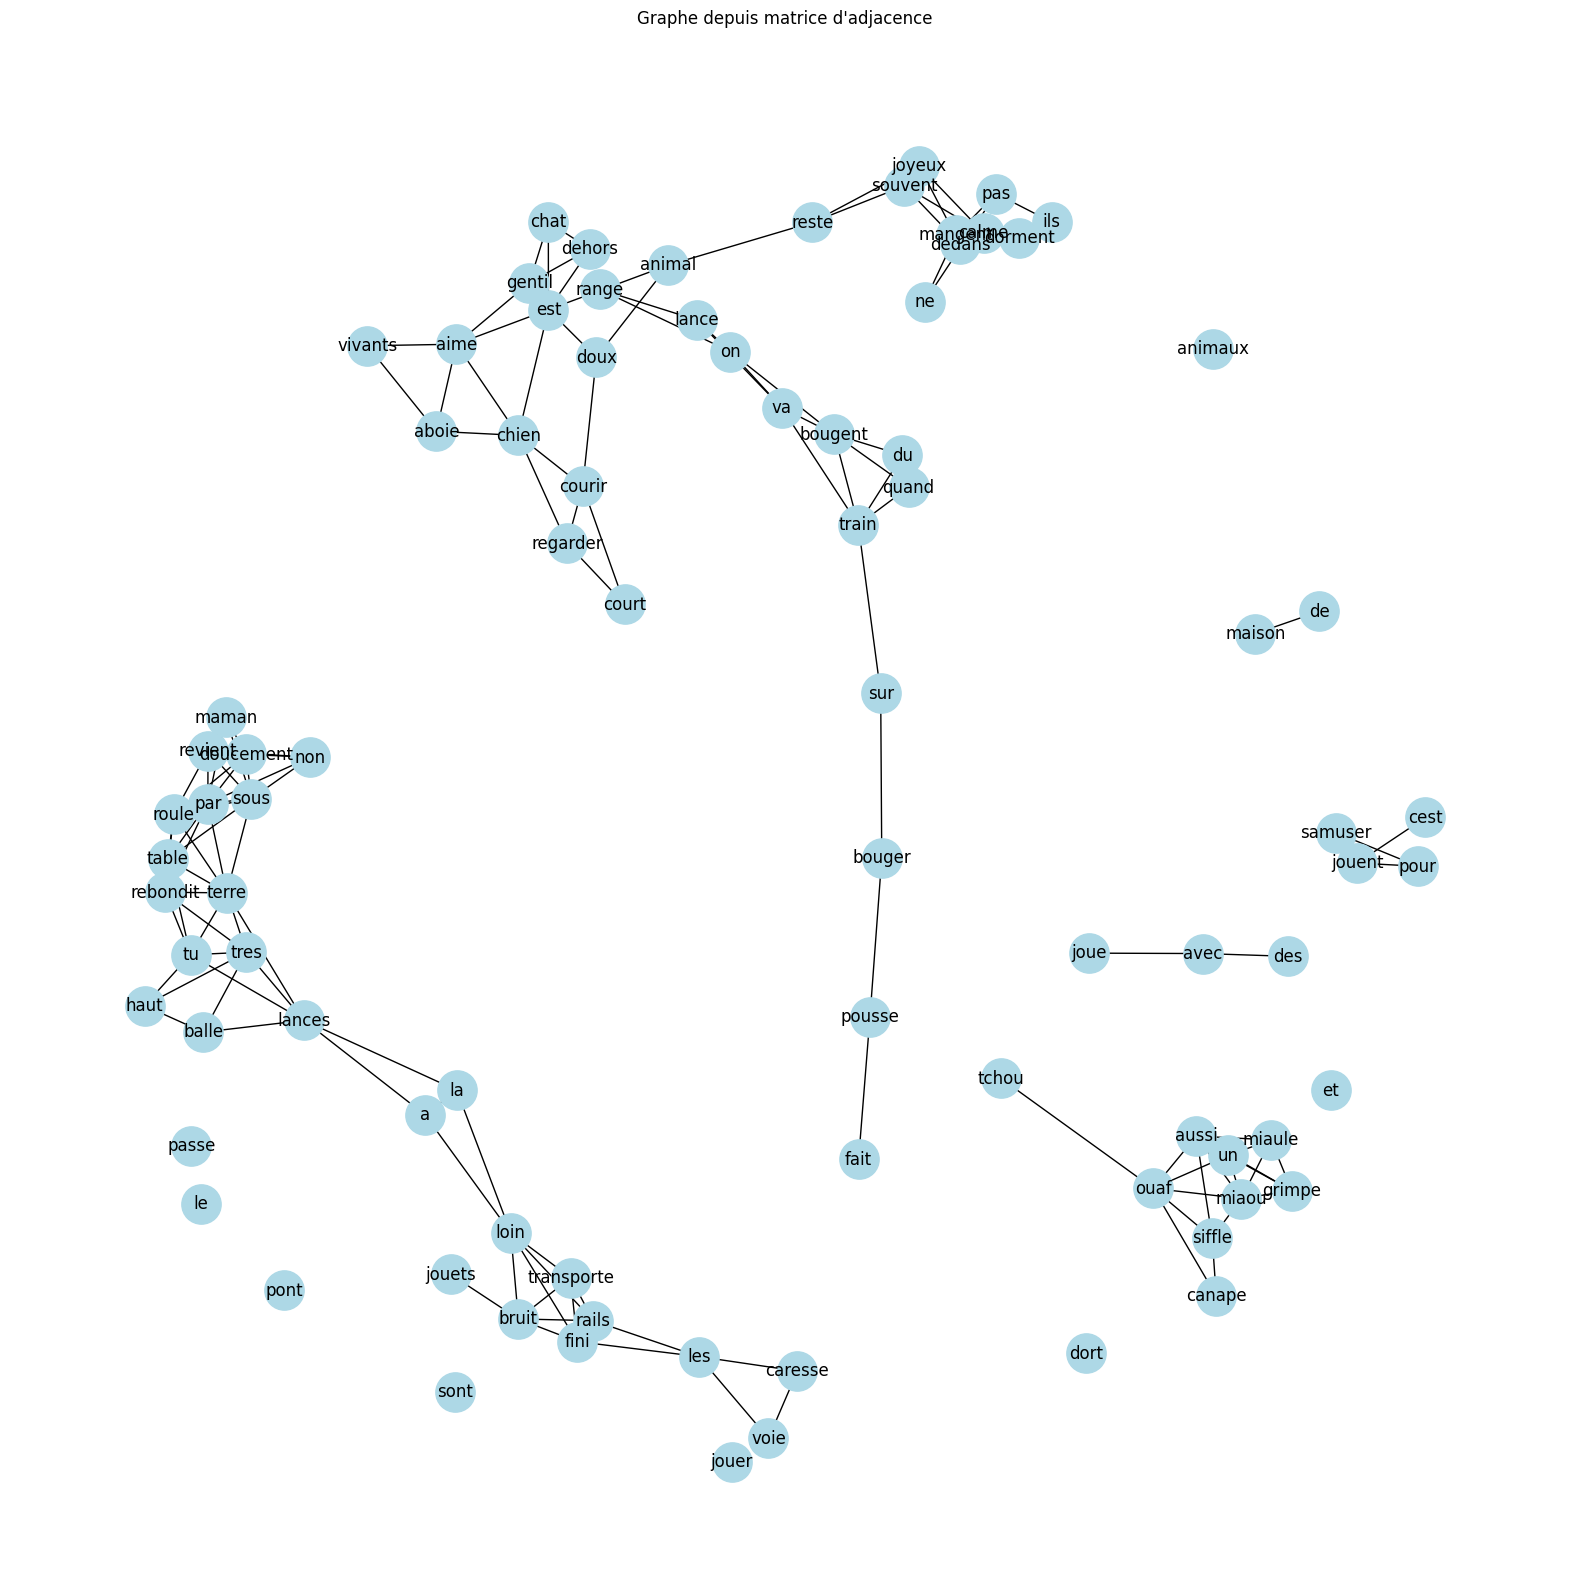

[[0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.99284 ... 0.      0.      0.     ]
 [0.      0.99284 0.      ... 0.      0.      0.     ]
 ...
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]
 [0.      0.      0.      ... 0.      0.      0.     ]]


In [4]:
def emb_to_graph(
        weights:np.ndarray,
        encoder:List
):
    
    adjacency_matrix = cosine_similarity(weights)

    thresh = np.quantile(adjacency_matrix, 0.95)  # garder les 5% plus fortes similarités
    adj_t = adjacency_matrix.copy()
    adj_t[adj_t < thresh] = 0

    adj_t = adj_t.round(5)

    np.fill_diagonal(adj_t, 0)

    mapping = encoder

    _, ax = plt.subplots(figsize = (20, 20))
    G = nx.from_numpy_array(adj_t)
    G = nx.relabel_nodes(G, mapping)
    nx.write_gexf(G, "test.gexf")
    pos = nx.spring_layout(G, dim=2, k=0.8, iterations=200)
    weights_graph = [G[u][v].get('weight', 1) for u, v in G.edges()]

    pos = {n: 10.0 * coords for n, coords in pos.items()}
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, ax=ax)
    # nx.draw_networkx_edge_labels(G, pos, ) #, edge_labels=nx.get_edge_attributes(G, 'weight'))

    
    plt.title('Graphe depuis matrice d\'adjacence')
    plt.show()

    return adj_t, adjacency_matrix

# print(word_weights.shape)
am , adjacency_matrix= emb_to_graph(word_weights, decoder)
print(am)

In [5]:
def project_and_plot(embeddings, encoder:dict, decoder:dict, dirs_words:List[str], top_n:int=200, plotly:bool=True):
    """
    embeddings: np.ndarray (V,D) or torch.Tensor (V,D)
    vocab: list of V tokens
    dirs_words: list of 2 or 3 tokens (must be in vocab)
    top_n: how many labels to display (highest |x|+|y|(+|z|)
    interactive: True -> plotly, False -> matplotlib
    """

    if isinstance(embeddings, torch.Tensor):
        embs = embeddings.detach().cpu().numpy()
    else:
        embs = np.asarray(embeddings)

    embs = normalize(embs)

    V, D = embs.shape
    assert len(dirs_words) in (2, 3), "dirs_words must be 2 or 3 tokens"
    for w in dirs_words:
        assert w in encoder.keys(), f'can t encode word {w} '
    
    anchors_list = []
    for item in dirs_words:
        w = item
        if w not in encoder:
            raise ValueError(f"direction token '{w}' not in vocab")
        anchors_list.append(embs[encoder[w]])
    anchors = np.stack(anchors_list, axis=0)  # (k, D)

    # center embeddings and anchors by global mean (centrage des vecteurs)
    mean_all = embs.mean(axis=0)
    embs_c = embs - mean_all
    anchors_c = anchors - mean_all

    # orthogonalize anchors via Gram-Schmidt and normalize
    def gram_schmidt(vecs):
        ortho = []
        for v in vecs:
            w = v.copy()
            for u in ortho:
                w = w - np.dot(w, u) * u
            norm = np.linalg.norm(w)
            if norm < 1e-8:
                continue
            ortho.append(w / norm)
        return np.stack(ortho, axis=0)
    
    dirs = gram_schmidt(anchors_c)  # (k_eff, D)
    k = dirs.shape[0]
    if k < len(dirs_words):
        # some directions were collinear; that's fine, continue with fewer axes
        pass

    # project
    coords = embs_c.dot(dirs.T)  # (V, k)
    mags = np.sum(np.abs(coords), axis=1)
    order = np.argsort(-mags)[:min(top_n, V)]
    xs = coords[order, 0]
    ys = coords[order, 1]
    labels = [decoder[i] for i in order]
    zs = coords[order, 2] if dirs.shape[0] == 3 else None

    if plotly:
        if zs is None:
            fig = go.Figure(data=go.Scatter(
                x=xs, y=ys, mode='markers+text',
                text=labels, textposition='top center',
                marker=dict(size=6, opacity=0.8)
            ))
            fig.update_layout(
                xaxis_title=str(dirs_words[0]),
                yaxis_title=str(dirs_words[1]),
                title="Projection 2D"
            )
        else:
            fig = go.Figure(data=go.Scatter3d(
                x=xs, y=ys, z=zs, mode='markers+text',
                text=labels, textposition='top center',
                marker=dict(size=4, opacity=0.8)
            ))
            fig.update_layout(
                scene=dict(
                    xaxis_title=str(dirs_words[0]),
                    yaxis_title=str(dirs_words[1]),
                    zaxis_title=str(dirs_words[2])
                ),
                title="Projection 3D"
            )
        fig.show()

    else :
        plt.figure(figsize=(9,7))
        plt.scatter(xs, ys, s=8, alpha=0.7)
        for i, lab in enumerate(labels):
            plt.annotate(lab, (xs[i], ys[i]), fontsize=9)
        plt.axhline(0, color='gray', linewidth=0.5)
        plt.axvline(0, color='gray', linewidth=0.5)
        plt.xlabel(f"dir: {dirs_words[0]}")
        plt.ylabel(f"dir: {dirs_words[1]}")
        plt.title("Projection 2D sur directions indiquées")
        plt.show()



In [6]:
project_and_plot(word_weights, encoder=encoder, decoder=decoder, dirs_words=["chat", 'jouer'], plotly=True)

In [7]:
cos = cosine_similarity(word_weights[encoder["chat"]].reshape(1, -1), word_weights[encoder["caresse"]].reshape(1, -1))[0,0]
print(cos)
cos = cosine_similarity(word_weights[encoder["jouer"]].reshape(1, -1), word_weights[encoder["caresse"]].reshape(1, -1))[0,0]
print(cos)

-0.22753519
-0.1706355


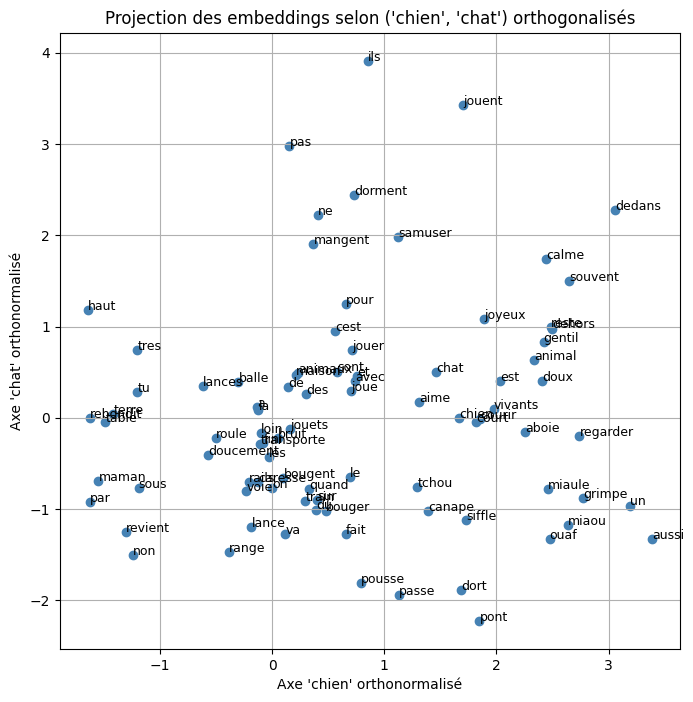

In [8]:
# Generate by GPT 5 (et modifié par moi)

# Vecteurs de référence
v_chien = word_weights[encoder['chien']]
v_chat = word_weights[encoder['chat']]

# === Étape 1 : Gram-Schmidt pour orthogonaliser ===
u1 = v_chien
proj = (np.dot(v_chat, u1) / np.dot(u1, u1)) * u1
u2 = v_chat - proj

# Normalisation
e1 = u1 / np.linalg.norm(u1)
e2 = u2 / np.linalg.norm(u2)

# === Étape 2 : Projection de tous les mots ===
coords = []
for mot, idx in encoder.items():
    v = word_weights[idx]
    x = np.dot(v, e1)
    y = np.dot(v, e2)
    coords.append((mot, x, y))

# === Étape 3 : Visualisation ===
plt.figure(figsize=(8,8))
for mot, x, y in coords:
    plt.scatter(x, y, color='steelblue')
    plt.text(x+0.002, y+0.002, mot, fontsize=9)

plt.xlabel("Axe 'chien' orthonormalisé")
plt.ylabel("Axe 'chat' orthonormalisé")
plt.title("Projection des embeddings selon ('chien', 'chat') orthogonalisés")
plt.grid(True)
plt.show()


In [9]:
mots_ref = ["chien", "chat", "train", "balle"]  # Pas limiter a 3


# Extraire les vecteurs
V = [word_weights[encoder[m]] for m in mots_ref]

# === Étape 1 : Gram-Schmidt pour orthogonaliser ===
E = []
for v in V:
    u = v.copy()
    for e in E:
        u -= np.dot(u, e) * e
    u = u / np.linalg.norm(u)
    E.append(u)

# === Étape 2 : Projection des mots ===
X, Y, Z, labels = [], [], [], []

for mot, idx in encoder.items() :
    v = word_weights[idx]
    # projection sur les 3 premiers axes de la base orthonormée
    proj = [np.dot(v, e) for e in E[:3]]
    X.append(proj[0])
    Y.append(proj[1])
    Z.append(proj[2])
    labels.append(mot)

fig = go.Figure(data=[
    go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers+text',
        text=labels,
        textposition="top center",
        marker=dict(size=4, color='steelblue', opacity=0.7)
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title=f"Axe 1 ({mots_ref[0]})",
        yaxis_title=f"Axe 2 ({mots_ref[1]})",
        zaxis_title=f"Axe 3 ({mots_ref[2]})",
    ),
    title="Projection orthonormée des embeddings Word2Vec (Plotly 3D)",
    width=900, height=800
)

fig.show()
